# Application: The Samuelson Multiplier-Accelerator

## Contents

- [Application: The Samuelson Multiplier-Accelerator](#Application:-The-Samuelson-Multiplier-Accelerator)  
  - [Overview](#Overview)  
  - [Details](#Details)  
  - [Implementation](#Implementation)  
  - [Stochastic Shocks](#Stochastic-Shocks)  
  - [Government Spending](#Government-Spending)  
  - [Wrapping Everything Into a Class](#Wrapping-Everything-Into-a-Class)  
  - [Using the LinearStateSpace Class](#Using-the-LinearStateSpace-Class)  
  - [Pure Multiplier Model](#Pure-Multiplier-Model)  
  - [Summary](#Summary)  

In addition to what’s in Anaconda, this lecture will need the following libraries:

In [1]:
!conda install -y quantecon

Solving environment: done

# All requested packages already installed.



## Overview

This lecture creates non-stochastic and stochastic versions of Paul Samuelson’s celebrated multiplier accelerator model [[Sam39]](https://python.quantecon.org/zreferences.html#samuelson1939).

In doing so, we extend the example of the Solow model class in [our second OOP lecture](https://python-programming.quantecon.org/python_oop.html).

Our objectives are to

- provide a more detailed example of OOP and classes  
- review a famous model  
- review linear difference equations, both deterministic and stochastic  


Let’s start with some standard imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We’ll also use the following for various tasks described below:

In [3]:
from quantecon import LinearStateSpace
import cmath
import math
import sympy
from sympy import Symbol, init_printing
from cmath import sqrt

### Samuelson’s Model

Samuelson used a *second-order linear difference equation* to
represent a model of national output based on three components:

- a *national output identity* asserting that national output or national income is the
  sum of consumption plus investment plus government purchases.  
- a Keynesian *consumption function* asserting that consumption at
  time $ t $ is equal to a constant times national output at time $ t-1 $.  
- an investment *accelerator* asserting that investment at time
  $ t $ equals a constant called the *accelerator coefficient*
  times the difference in output between period $ t-1 $ and
  $ t-2 $.  


Consumption plus investment plus government purchases
constitute *aggregate demand,* which automatically calls forth an
equal amount of *aggregate supply*.

(To read about linear difference equations see [here](https://en.wikipedia.org/wiki/Linear_difference_equation) or chapter IX of [[Sar87]](https://python.quantecon.org/zreferences.html#sargent1987).)

Samuelson used the model to analyze how particular values of the
marginal propensity to consume and the accelerator coefficient might
give rise to transient *business cycles* in national output.

Possible dynamic properties include

- smooth convergence to a constant level of output  
- damped business cycles that eventually converge to a constant level
  of output  
- persistent business cycles that neither dampen nor explode  


Later we present an extension that
adds a random shock to the right side of the national income
identity representing random fluctuations in aggregate demand.

This modification makes national output become governed by a second-order
*stochastic linear difference equation* that, with appropriate parameter values,
gives rise to recurrent irregular business cycles.

(To read about stochastic linear difference equations see chapter XI of
[[Sar87]](https://python.quantecon.org/zreferences.html#sargent1987).)

## Details

Let’s assume that

- $ \{G_t\} $ is a sequence of levels of government expenditures –
  we’ll start by setting $ G_t = G $ for all $ t $.  
- $ \{C_t\} $ is a sequence of levels of aggregate consumption
  expenditures, a key endogenous variable in the model.  
- $ \{I_t\} $ is a sequence of rates of investment, another key
  endogenous variable.  
- $ \{Y_t\} $ is a sequence of levels of national income, yet
  another endogenous variable.  


- $ a $ is the marginal propensity to consume in the Keynesian
  consumption function $ C_t = a Y_{t-1} + \gamma $.  
- $ b $ is the “accelerator coefficient” in the “investment
  accelerator” $ I_t = b (Y_{t-1} - Y_{t-2}) $.  
- $ \{\epsilon_{t}\} $ is an IID sequence standard normal random variables.  
- $ \sigma \geq 0 $ is a “volatility”
  parameter — setting $ \sigma = 0 $ recovers the non-stochastic case
  that we’ll start with.  


The model combines the consumption function


<a id='equation-consumption'></a>
$$
C_t = a Y_{t-1} + \gamma \tag{1}
$$

with the investment accelerator


<a id='equation-accelerator'></a>
$$
I_t = b (Y_{t-1} - Y_{t-2}) \tag{2}
$$

and the national income identity


<a id='equation-income-identity'></a>
$$
Y_t = C_t + I_t + G_t \tag{3}
$$

- The parameter $ a $ is peoples’ *marginal propensity to consume*
  out of income - equation [(15.1)](#equation-consumption) asserts that people consume a fraction of
  math:a in (0,1) of each additional dollar of income.  
- The parameter $ b > 0 $ is the investment accelerator coefficient - equation
  [(15.2)](#equation-accelerator) asserts that people invest in physical capital when
  income is increasing and disinvest when it is decreasing.  


Equations [(15.1)](#equation-consumption), [(15.2)](#equation-accelerator), and [(15.3)](#equation-income-identity)
imply the following second-order linear difference equation for national income:

$$
Y_t = (a+b) Y_{t-1} - b Y_{t-2} + (\gamma + G_t)
$$

or


<a id='equation-second-order'></a>
$$
Y_t = \rho_1 Y_{t-1} + \rho_2 Y_{t-2} + (\gamma + G_t) \tag{4}
$$

where $ \rho_1 = (a+b) $ and $ \rho_2 = -b $.

To complete the model, we require two **initial conditions**.

If the model is to generate time series for $ t=0, \ldots, T $, we
require initial values

$$
Y_{-1} = \bar Y_{-1}, \quad  Y_{-2} = \bar Y_{-2}
$$

We’ll ordinarily set the parameters $ (a,b) $ so that starting from
an arbitrary pair of initial conditions
$ (\bar Y_{-1}, \bar Y_{-2}) $, national income $ Y_t $ converges to
a constant value as $ t $ becomes large.

We are interested in studying

- the transient fluctuations in $ Y_t $ as it converges to its
  **steady state** level  
- the **rate** at which it converges to a steady state level  


The deterministic version of the model described so far — meaning that
no random shocks hit aggregate demand — has only transient fluctuations.

We can convert the model to one that has persistent irregular
fluctuations by adding a random shock to aggregate demand.

### Stochastic Version of the Model

We create a **random** or **stochastic** version of the model by adding
a random process of **shocks** or **disturbances**
$ \{\sigma \epsilon_t \} $ to the right side of equation [(15.4)](#equation-second-order),
leading to the **second-order scalar linear stochastic difference
equation**:


<a id='equation-second-stochastic'></a>
$$
Y_t = G_t + a (1-b) Y_{t-1} - a b Y_{t-2} + \sigma \epsilon_{t} \tag{5}
$$

### Mathematical Analysis of the Model

To get started, let’s set $ G_t \equiv 0 $, $ \sigma = 0 $, and
$ \gamma = 0 $.

Then we can write equation [(15.5)](#equation-second-stochastic) as

$$
Y_t = \rho_1 Y_{t-1} + \rho_2 Y_{t-2}
$$

or


<a id='equation-second-stochastic2'></a>
$$
Y_{t+2} - \rho_1 Y_{t+1} - \rho_2 Y_t  = 0 \tag{6}
$$

To discover the properties of the solution of [(15.6)](#equation-second-stochastic2),
it is useful first to form the **characteristic polynomial**
for [(15.6)](#equation-second-stochastic2):


<a id='equation-polynomial'></a>
$$
z^2 - \rho_1 z  - \rho_2 \tag{7}
$$

where $ z $ is possibly a complex number.

We want to find the two **zeros** (a.k.a. **roots**) – namely
$ \lambda_1, \lambda_2 $ – of the characteristic polynomial.

These are two special values of $ z $, say $ z= \lambda_1 $ and
$ z= \lambda_2 $, such that if we set $ z $ equal to one of
these values in expression [(15.7)](#equation-polynomial),
the characteristic polynomial [(15.7)](#equation-polynomial) equals zero:


<a id='equation-polynomial-sol'></a>
$$
z^2 - \rho_1 z  - \rho_2  = (z- \lambda_1 ) (z -\lambda_2) = 0 \tag{8}
$$

Equation [(15.8)](#equation-polynomial-sol) is said to **factor** the characteristic polynomial.

When the roots are complex, they will occur as a complex conjugate pair.

When the roots are complex, it is convenient to represent them in the
polar form

$$
\lambda_1 =  r e^{i \omega}, \  \lambda_2 = r e^{-i \omega}
$$

where $ r $ is the *amplitude* of the complex number and
$ \omega $ is its *angle* or *phase*.

These can also be represented as

$$
\lambda_1 = r (cos (\omega) + i \sin (\omega))
$$

$$
\lambda_2 = r (cos (\omega) - i \sin(\omega))
$$

(To read about the polar form, see
[here](https://www.khanacademy.org/math/precalculus/x9e81a4f98389efdf:complex/x9e81a4f98389efdf:complex-mul-div-polar/a/complex-number-polar-form-review))

Given **initial conditions** $ Y_{-1}, Y_{-2} $, we want to generate
a **solution** of the difference equation [(15.6)](#equation-second-stochastic2).

It can be represented as

$$
Y_t = \lambda_1^t c_1 + \lambda_2^t c_2
$$

where $ c_1 $ and $ c_2 $ are constants that depend on the two
initial conditions and on $ \rho_1, \rho_2 $.

When the roots are complex, it is useful to pursue the following calculations.

Notice that

$$
\begin{aligned}
  Y_t & =  & c_1 (r e^{i \omega})^t + c_2 (r e^{-i \omega})^t  \\
   & = & c_1 r^t e^{i\omega t} + c_2 r^t e^{-i \omega t} \\
   & = &  c_1 r^t [\cos(\omega t) + i \sin(\omega t) ] + c_2 r^t [\cos(\omega t) - i \sin(\omega t) ] \\
   & = & (c_1 + c_2) r^t \cos(\omega t) + i (c_1 - c_2) r^t \sin(\omega t)
 \end{aligned}
$$

The only way that $ Y_t $ can be a  real number for each $ t $ is if $ c_1 + c_2 $ is a real number and $ c_1 - c_2 $ is an imaginary number.

This happens only when $ c_1 $ and $ c_2 $ are complex conjugates, in which case they can be written in the polar forms

$$
c_1 = v e^{i \theta},  \  \ c_2 = v e^{- i \theta}
$$

So we can write

$$
\begin{aligned}
  Y_t & = & v e^{i \theta} r^t e^{i \omega t} + v e ^{- i \theta} r^t e^{-i \omega t} \\
      & = & v r^t [ e^{i(\omega t + \theta)} + e^{-i (\omega t +\theta)}]  \\
      & = & 2 v r^t  \cos (\omega t + \theta)
 \end{aligned}
$$

where $ v $ and $ \theta $ are constants that must be chosen to satisfy initial conditions for $ Y_{-1}, Y_{-2} $.

This formula shows that when the roots are complex, $ Y_t $ displays
oscillations with **period** $ \check p =
\frac{2 \pi}{\omega} $ and **damping factor** $ r $.

We say that $ \check p $ is the **period** because in that amount of time the cosine wave $ \cos(\omega t + \theta) $ goes through exactly one complete cycles.

(Draw a cosine function to convince yourself of this please)

**Remark:** Following [[Sam39]](https://python.quantecon.org/zreferences.html#samuelson1939), we want to choose the parameters
$ a, b $ of the model so that the absolute values (of the possibly
complex) roots $ \lambda_1, \lambda_2 $ of the characteristic
polynomial are both strictly less than one:

$$
| \lambda_j | < 1 \quad \quad \text{for } j = 1, 2
$$

**Remark:** When both roots  $ \lambda_1, \lambda_2 $ of the characteristic polynomial have
absolute values strictly less than one, the absolute value of the larger
one governs the rate of convergence to the steady state of the non
stochastic version of the model.

### Things This Lecture Does

We write a function to generate simulations of a $ \{Y_t\} $ sequence as a function of time.

The function requires that we put in initial conditions for $ Y_{-1}, Y_{-2} $.

The function checks that $ a, b $ are set so that $ \lambda_1, \lambda_2 $ are less than
unity in absolute value (also called “modulus”).

The function also tells us whether the roots are complex, and, if they are complex, returns both their real and complex parts.

If the roots are both real, the function returns their values.

We use our function written to simulate paths that are stochastic (when $ \sigma >0 $).

We have written the function in a way that allows us to input $ \{G_t\} $ paths of a few simple forms, e.g.,

- one time jumps in $ G $ at some time  
- a permanent jump in $ G $ that occurs at some time  


We proceed to use the Samuelson multiplier-accelerator model as a laboratory to make a simple OOP example.

The “state” that determines next period’s $ Y_{t+1} $ is now not just the current value $ Y_t $ but also the once lagged value $ Y_{t-1} $.

This involves a little more bookkeeping than is required in the Solow model class definition.

We use the Samuelson multiplier-accelerator model as a vehicle for teaching how we can gradually add more features to the class.

We want to have a method in the class that automatically generates a simulation, either non-stochastic ($ \sigma=0 $) or stochastic ($ \sigma > 0 $).

We also show how to map the Samuelson model into a simple instance of the `LinearStateSpace` class described [here](https://python.quantecon.org/linear_models.html).

We can use a `LinearStateSpace` instance to do various things that we did above with our homemade function and class.

Among other things, we show by example that the eigenvalues of the matrix $ A $ that we use to form the instance of the `LinearStateSpace` class for the Samuelson model equal the roots of the characteristic polynomial [(15.7)](#equation-polynomial) for the Samuelson multiplier accelerator model.

Here is the formula for the matrix $ A $ in the linear state space system in the case that government expenditures are a constant $ G $:

$$
A = \begin{bmatrix} 1 & 0 & 0 \cr
                      \gamma + G & \rho_1 & \rho_2 \cr
                      0 & 1 & 0 \end{bmatrix}
$$

## Implementation

We’ll start by drawing an informative graph from page 189 of [[Sar87]](https://python.quantecon.org/zreferences.html#sargent1987)

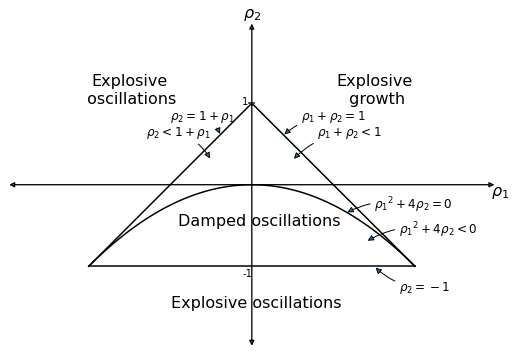

In [4]:
def param_plot():

    """This function creates the graph on page 189 of
    Sargent Macroeconomic Theory, second edition, 1987.
    """

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_aspect('equal')

    # Set axis
    xmin, ymin = -3, -2
    xmax, ymax = -xmin, -ymin
    plt.axis([xmin, xmax, ymin, ymax])

    # Set axis labels
    ax.set(xticks=[], yticks=[])
    ax.set_xlabel(r'$\rho_2$', fontsize=16)
    ax.xaxis.set_label_position('top')
    ax.set_ylabel(r'$\rho_1$', rotation=0, fontsize=16)
    ax.yaxis.set_label_position('right')

    # Draw (t1, t2) points
    ρ1 = np.linspace(-2, 2, 100)
    ax.plot(ρ1, -abs(ρ1) + 1, c='black')
    ax.plot(ρ1, np.ones_like(ρ1) * -1, c='black')
    ax.plot(ρ1, -(ρ1**2 / 4), c='black')

    # Turn normal axes off
    for spine in ['left', 'bottom', 'top', 'right']:
        ax.spines[spine].set_visible(False)

    # Add arrows to represent axes
    axes_arrows = {'arrowstyle': '<|-|>', 'lw': 1.3}
    ax.annotate('', xy=(xmin, 0), xytext=(xmax, 0), arrowprops=axes_arrows)
    ax.annotate('', xy=(0, ymin), xytext=(0, ymax), arrowprops=axes_arrows)

    # Annotate the plot with equations
    plot_arrowsl = {'arrowstyle': '-|>', 'connectionstyle': "arc3, rad=-0.2"}
    plot_arrowsr = {'arrowstyle': '-|>', 'connectionstyle': "arc3, rad=0.2"}
    ax.annotate(r'$\rho_1 + \rho_2 < 1$', xy=(0.5, 0.3), xytext=(0.8, 0.6),
                arrowprops=plot_arrowsr, fontsize='12')
    ax.annotate(r'$\rho_1 + \rho_2 = 1$', xy=(0.38, 0.6), xytext=(0.6, 0.8),
                arrowprops=plot_arrowsr, fontsize='12')
    ax.annotate(r'$\rho_2 < 1 + \rho_1$', xy=(-0.5, 0.3), xytext=(-1.3, 0.6),
                arrowprops=plot_arrowsl, fontsize='12')
    ax.annotate(r'$\rho_2 = 1 + \rho_1$', xy=(-0.38, 0.6), xytext=(-1, 0.8),
                arrowprops=plot_arrowsl, fontsize='12')
    ax.annotate(r'$\rho_2 = -1$', xy=(1.5, -1), xytext=(1.8, -1.3),
                arrowprops=plot_arrowsl, fontsize='12')
    ax.annotate(r'${\rho_1}^2 + 4\rho_2 = 0$', xy=(1.15, -0.35),
                xytext=(1.5, -0.3), arrowprops=plot_arrowsr, fontsize='12')
    ax.annotate(r'${\rho_1}^2 + 4\rho_2 < 0$', xy=(1.4, -0.7),
                xytext=(1.8, -0.6), arrowprops=plot_arrowsr, fontsize='12')

    # Label categories of solutions
    ax.text(1.5, 1, 'Explosive\n growth', ha='center', fontsize=16)
    ax.text(-1.5, 1, 'Explosive\n oscillations', ha='center', fontsize=16)
    ax.text(0.05, -1.5, 'Explosive oscillations', ha='center', fontsize=16)
    ax.text(0.09, -0.5, 'Damped oscillations', ha='center', fontsize=16)

    # Add small marker to y-axis
    ax.axhline(y=1.005, xmin=0.495, xmax=0.505, c='black')
    ax.text(-0.12, -1.12, '-1', fontsize=10)
    ax.text(-0.12, 0.98, '1', fontsize=10)

    return fig

param_plot()
plt.show()

The graph portrays regions in which the $ (\lambda_1, \lambda_2) $
root pairs implied by the $ (\rho_1 = (a+b), \rho_2 = - b) $
difference equation parameter pairs in the Samuelson model are such that:

- $ (\lambda_1, \lambda_2) $ are complex with modulus less than
  $ 1 $ - in this case, the $ \{Y_t\} $ sequence displays damped
  oscillations.  
- $ (\lambda_1, \lambda_2) $ are both real, but one is strictly
  greater than $ 1 $ - this leads to explosive growth.  
- $ (\lambda_1, \lambda_2) $ are both real, but one is strictly
  less than $ -1 $ - this leads to explosive oscillations.  
- $ (\lambda_1, \lambda_2) $ are both real and both are less than
  $ 1 $ in absolute value - in this case, there is smooth
  convergence to the steady state without damped cycles.  


Later we’ll present the graph with a red mark showing the particular
point implied by the setting of $ (a,b) $.

### Function to Describe Implications of Characteristic Polynomial

In [5]:
def categorize_solution(ρ1, ρ2):

    """This function takes values of ρ1 and ρ2 and uses them
    to classify the type of solution
    """

    discriminant = ρ1 ** 2 + 4 * ρ2
    if ρ2 > 1 + ρ1 or ρ2 < -1:
        print('Explosive oscillations')
    elif ρ1 + ρ2 > 1:
        print('Explosive growth')
    elif discriminant < 0:
        print('Roots are complex with modulus less than one; \
therefore damped oscillations')
    else:
        print('Roots are real and absolute values are less than one; \
therefore get smooth convergence to a steady state')

In [6]:
### Test the categorize_solution function

categorize_solution(1.3, -.4)

Roots are real and absolute values are less than one; therefore get smooth convergence to a steady state


### Function for Plotting Paths

A useful function for our work below is

In [7]:
def plot_y(function=None):

    """Function plots path of Y_t"""

    plt.subplots(figsize=(10, 6))
    plt.plot(function)
    plt.xlabel('Time $t$')
    plt.ylabel('$Y_t$', rotation=0)
    plt.grid()
    plt.show()

### Manual or “by hand” Root Calculations

The following function calculates roots of the characteristic polynomial
using high school algebra.

(We’ll calculate the roots in other ways later)

The function also plots a $ Y_t $ starting from initial conditions
that we set

ρ_1 is 1.42
ρ_2 is -0.5
Two real roots: 
[-0.6459687576256715, -0.7740312423743284]
Absolute values of roots are less than one


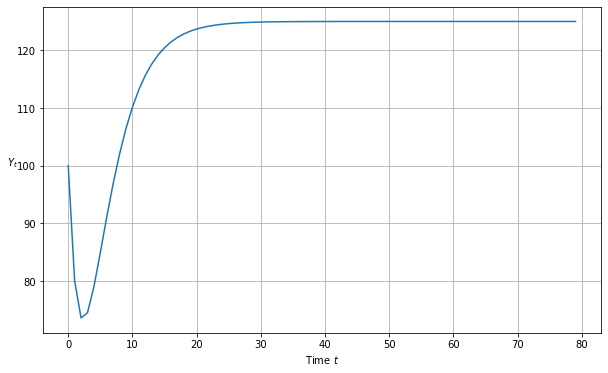

In [8]:
# This is a 'manual' method

def y_nonstochastic(y_0=100, y_1=80, α=.92, β=.5, γ=10, n=80):

    """Takes values of parameters and computes the roots of characteristic
    polynomial. It tells whether they are real or complex and whether they
    are less than unity in absolute value.It also computes a simulation of
    length n starting from the two given initial conditions for national
    income
    """

    roots = []

    ρ1 = α + β
    ρ2 = -β

    print(f'ρ_1 is {ρ1}')
    print(f'ρ_2 is {ρ2}')

    discriminant = ρ1 ** 2 + 4 * ρ2

    if discriminant == 0:
        roots.append(-ρ1 / 2)
        print('Single real root: ')
        print(''.join(str(roots)))
    elif discriminant > 0:
        roots.append((-ρ1 + sqrt(discriminant).real) / 2)
        roots.append((-ρ1 - sqrt(discriminant).real) / 2)
        print('Two real roots: ')
        print(''.join(str(roots)))
    else:
        roots.append((-ρ1 + sqrt(discriminant)) / 2)
        roots.append((-ρ1 - sqrt(discriminant)) / 2)
        print('Two complex roots: ')
        print(''.join(str(roots)))

    if all(abs(root) < 1 for root in roots):
        print('Absolute values of roots are less than one')
    else:
        print('Absolute values of roots are not less than one')

    def transition(x, t): return ρ1 * x[t - 1] + ρ2 * x[t - 2] + γ

    y_t = [y_0, y_1]

    for t in range(2, n):
        y_t.append(transition(y_t, t))

    return y_t

plot_y(y_nonstochastic())

### Reverse-Engineering Parameters to Generate Damped Cycles

The next cell writes code that takes as inputs the modulus $ r $ and
phase $ \phi $ of a conjugate pair of complex numbers in polar form

$$
\lambda_1 = r \exp(i \phi), \quad \lambda_2 = r \exp(- i \phi)
$$

- The code assumes that these two complex numbers are the roots of the
  characteristic polynomial  
- It then reverse-engineers $ (a,b) $ and $ (\rho_1, \rho_2) $,
  pairs that would generate those roots  

In [9]:
### code to reverse-engineer a cycle
### y_t = r^t (c_1 cos(ϕ t) + c2 sin(ϕ t))
###

def f(r, ϕ):
    """
    Takes modulus r and angle ϕ of complex number r exp(j ϕ)
    and creates ρ1 and ρ2 of characteristic polynomial for which
    r exp(j ϕ) and r exp(- j ϕ) are complex roots.

    Returns the multiplier coefficient a and the accelerator coefficient b
    that verifies those roots.
    """
    g1 = cmath.rect(r, ϕ)  # Generate two complex roots
    g2 = cmath.rect(r, -ϕ)
    ρ1 = g1 + g2           # Implied ρ1, ρ2
    ρ2 = -g1 * g2
    b = -ρ2                # Reverse-engineer a and b that validate these
    a = ρ1 - b
    return ρ1, ρ2, a, b

## Now let's use the function in an example
## Here are the example parameters

r = .95
period = 10                # Length of cycle in units of time
ϕ = 2 * math.pi/period

## Apply the function

ρ1, ρ2, a, b = f(r, ϕ)

print(f"a, b = {a}, {b}")
print(f"ρ1, ρ2 = {ρ1}, {ρ2}")

a, b = (0.6346322893124001+0j), (0.9024999999999999-0j)
ρ1, ρ2 = (1.5371322893124+0j), (-0.9024999999999999+0j)


In [10]:
## Print the real components of ρ1 and ρ2

ρ1 = ρ1.real
ρ2 = ρ2.real

ρ1, ρ2

(1.5371322893124, -0.9024999999999999)

### Root Finding Using Numpy

Here we’ll use numpy to compute the roots of the characteristic
polynomial

In [11]:
r1, r2 = np.roots([1, -ρ1, -ρ2])

p1 = cmath.polar(r1)
p2 = cmath.polar(r2)

print(f"r, ϕ = {r}, {ϕ}")
print(f"p1, p2 = {p1}, {p2}")
# print(f"g1, g2 = {g1}, {g2}")

print(f"a, b = {a}, {b}")
print(f"ρ1, ρ2 = {ρ1}, {ρ2}")

r, ϕ = 0.95, 0.6283185307179586
p1, p2 = (0.95, 0.6283185307179586), (0.95, -0.6283185307179586)
a, b = (0.6346322893124001+0j), (0.9024999999999999-0j)
ρ1, ρ2 = 1.5371322893124, -0.9024999999999999


Roots are complex with modulus less than one; therefore damped oscillations
Roots are [0.85+0.27838822j 0.85-0.27838822j]
Roots are complex
Roots are less than one


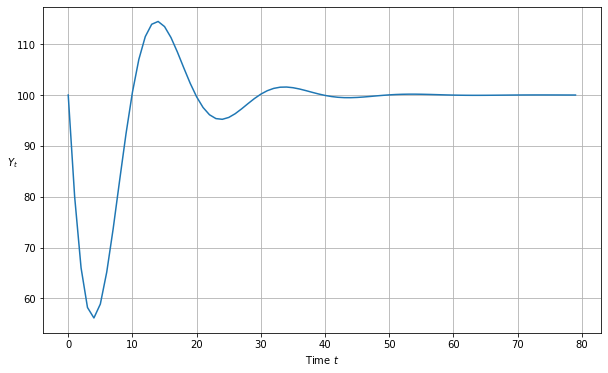

In [12]:
##=== This method uses numpy to calculate roots ===#


def y_nonstochastic(y_0=100, y_1=80, α=.9, β=.8, γ=10, n=80):

    """ Rather than computing the roots of the characteristic
    polynomial by hand as we did earlier, this function
    enlists numpy to do the work for us
    """

    # Useful constants
    ρ1 = α + β
    ρ2 = -β

    categorize_solution(ρ1, ρ2)

    # Find roots of polynomial
    roots = np.roots([1, -ρ1, -ρ2])
    print(f'Roots are {roots}')

    # Check if real or complex
    if all(isinstance(root, complex) for root in roots):
        print('Roots are complex')
    else:
        print('Roots are real')

    # Check if roots are less than one
    if all(abs(root) < 1 for root in roots):
        print('Roots are less than one')
    else:
        print('Roots are not less than one')

    # Define transition equation
    def transition(x, t): return ρ1 * x[t - 1] + ρ2 * x[t - 2] + γ

    # Set initial conditions
    y_t = [y_0, y_1]

    # Generate y_t series
    for t in range(2, n):
        y_t.append(transition(y_t, t))

    return y_t

plot_y(y_nonstochastic())

### Reverse-Engineered Complex Roots: Example

The next cell studies the implications of reverse-engineered complex
roots.

We’ll generate an **undamped** cycle of period 10

a, b = 0.6180339887498949, 1.0
Roots are complex with modulus less than one; therefore damped oscillations
Roots are [0.80901699+0.58778525j 0.80901699-0.58778525j]
Roots are complex
Roots are less than one


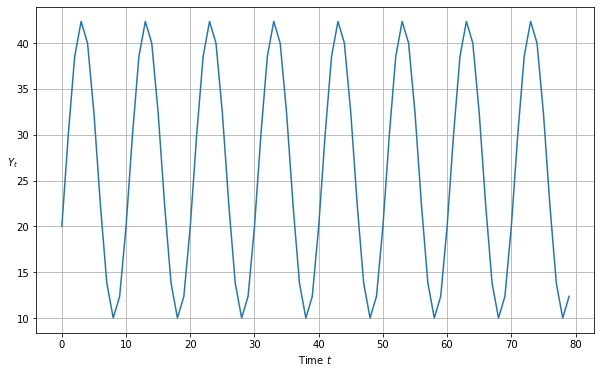

In [13]:
r = 1   # Generates undamped, nonexplosive cycles

period = 10   # Length of cycle in units of time
ϕ = 2 * math.pi/period

## Apply the reverse-engineering function f

ρ1, ρ2, a, b = f(r, ϕ)

# Drop the imaginary part so that it is a valid input into y_nonstochastic
a = a.real
b = b.real

print(f"a, b = {a}, {b}")

ytemp = y_nonstochastic(α=a, β=b, y_0=20, y_1=30)
plot_y(ytemp)

### Digression: Using Sympy to Find Roots

We can also use sympy to compute analytic formulas for the roots

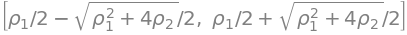

In [14]:
init_printing()

r1 = Symbol("ρ_1")
r2 = Symbol("ρ_2")
z = Symbol("z")

sympy.solve(z**2 - r1*z - r2, z)

$$
\left [ \frac{\rho_{1}}{2} - \frac{1}{2} \sqrt{\rho_{1}^{2} + 4 \rho_{2}},
\quad \frac{\rho_{1}}{2} + \frac{1}{2} \sqrt{\rho_{1}^{2} + 4 \rho_{2}}\right ]
$$

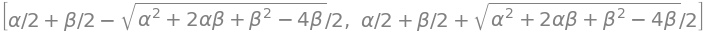

In [15]:
a = Symbol("α")
b = Symbol("β")
r1 = a + b
r2 = -b

sympy.solve(z**2 - r1*z - r2, z)

$$
\left [ \frac{\alpha}{2} + \frac{\beta}{2} - \frac{1}{2} \sqrt{\alpha^{2} +
2 \alpha \beta + \beta^{2} - 4 \beta}, \quad \frac{\alpha}{2} +
\frac{\beta}{2} + \frac{1}{2} \sqrt{\alpha^{2} + 2 \alpha \beta +
\beta^{2} - 4 \beta}\right ]
$$

## Stochastic Shocks

Now we’ll construct some code to simulate the stochastic version of the
model that emerges when we add a random shock process to aggregate
demand

Roots are real and absolute values are less than one; therefore get smooth convergence to a steady state
[0.7236068 0.2763932]
Roots are real
Roots are less than one


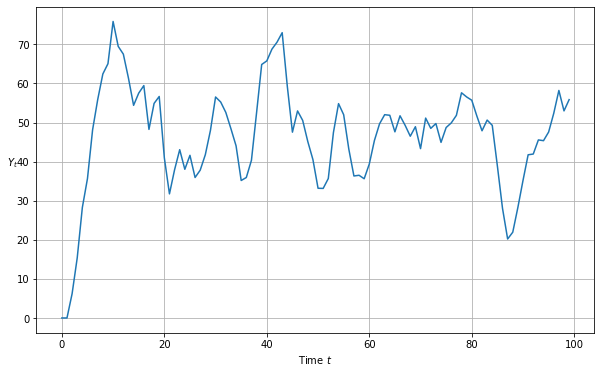

In [16]:
def y_stochastic(y_0=0, y_1=0, α=0.8, β=0.2, γ=10, n=100, σ=5):

    """This function takes parameters of a stochastic version of
    the model and proceeds to analyze the roots of the characteristic
    polynomial and also generate a simulation.
    """

    # Useful constants
    ρ1 = α + β
    ρ2 = -β

    # Categorize solution
    categorize_solution(ρ1, ρ2)

    # Find roots of polynomial
    roots = np.roots([1, -ρ1, -ρ2])
    print(roots)

    # Check if real or complex
    if all(isinstance(root, complex) for root in roots):
        print('Roots are complex')
    else:
        print('Roots are real')

    # Check if roots are less than one
    if all(abs(root) < 1 for root in roots):
        print('Roots are less than one')
    else:
        print('Roots are not less than one')

    # Generate shocks
    ϵ = np.random.normal(0, 1, n)

    # Define transition equation
    def transition(x, t): return ρ1 * \
        x[t - 1] + ρ2 * x[t - 2] + γ + σ * ϵ[t]

    # Set initial conditions
    y_t = [y_0, y_1]

    # Generate y_t series
    for t in range(2, n):
        y_t.append(transition(y_t, t))

    return y_t

plot_y(y_stochastic())

Let’s do a simulation in which there are shocks and the characteristic polynomial has complex roots

a, b = 0.6285929690873979, 0.9409000000000001
Roots are complex with modulus less than one; therefore damped oscillations
[0.78474648+0.57015169j 0.78474648-0.57015169j]
Roots are complex
Roots are less than one


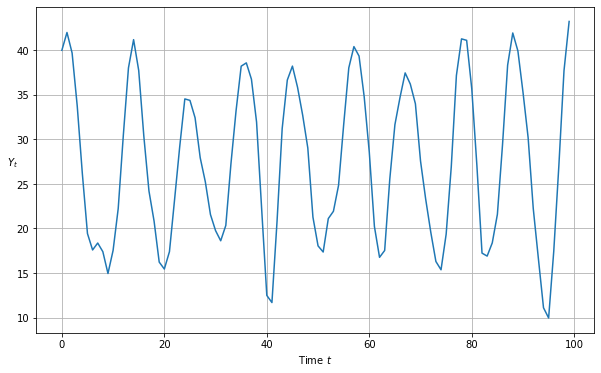

In [17]:
r = .97

period = 10   #  Length of cycle in units of time
ϕ = 2 * math.pi/period

### Apply the  reverse-engineering function f

ρ1, ρ2, a, b = f(r, ϕ)

# Drop the imaginary part so that it is a valid input into y_nonstochastic
a = a.real
b = b.real

print(f"a, b = {a}, {b}")
plot_y(y_stochastic(y_0=40, y_1 = 42, α=a, β=b, σ=2, n=100))

## Government Spending

This function computes a response to either a permanent or one-off increase
in government expenditures

In [18]:
def y_stochastic_g(y_0=20,
                   y_1=20,
                   α=0.8,
                   β=0.2,
                   γ=10,
                   n=100,
                   σ=2,
                   g=0,
                   g_t=0,
                   duration='permanent'):

    """This program computes a response to a permanent increase
    in government expenditures that occurs at time 20
    """

    # Useful constants
    ρ1 = α + β
    ρ2 = -β

    # Categorize solution
    categorize_solution(ρ1, ρ2)

    # Find roots of polynomial
    roots = np.roots([1, -ρ1, -ρ2])
    print(roots)

    # Check if real or complex
    if all(isinstance(root, complex) for root in roots):
        print('Roots are complex')
    else:
        print('Roots are real')

    # Check if roots are less than one
    if all(abs(root) < 1 for root in roots):
        print('Roots are less than one')
    else:
        print('Roots are not less than one')

    # Generate shocks
    ϵ = np.random.normal(0, 1, n)

    def transition(x, t, g):

        # Non-stochastic - separated to avoid generating random series
        # when not needed
        if σ == 0:
            return ρ1 * x[t - 1] + ρ2 * x[t - 2] + γ + g

        # Stochastic
        else:
            ϵ = np.random.normal(0, 1, n)
            return ρ1 * x[t - 1] + ρ2 * x[t - 2] + γ + g + σ * ϵ[t]

    # Create list and set initial conditions
    y_t = [y_0, y_1]

    # Generate y_t series
    for t in range(2, n):

        # No government spending
        if g == 0:
            y_t.append(transition(y_t, t))

        # Government spending (no shock)
        elif g != 0 and duration == None:
            y_t.append(transition(y_t, t))

        # Permanent government spending shock
        elif duration == 'permanent':
            if t < g_t:
                y_t.append(transition(y_t, t, g=0))
            else:
                y_t.append(transition(y_t, t, g=g))

        # One-off government spending shock
        elif duration == 'one-off':
            if t == g_t:
                y_t.append(transition(y_t, t, g=g))
            else:
                y_t.append(transition(y_t, t, g=0))
    return y_t

A permanent government spending shock can be simulated as follows

Roots are real and absolute values are less than one; therefore get smooth convergence to a steady state
[0.7236068 0.2763932]
Roots are real
Roots are less than one


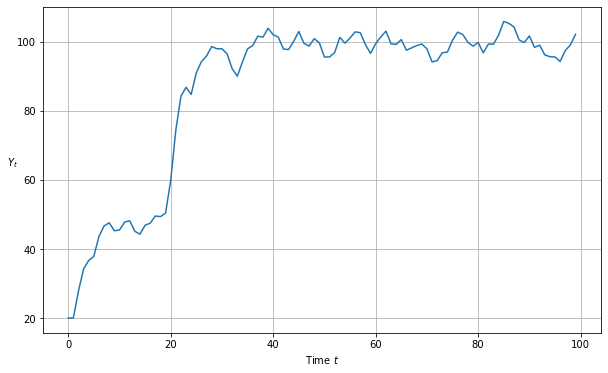

In [19]:
plot_y(y_stochastic_g(g=10, g_t=20, duration='permanent'))

We can also see the response to a one time jump in government expenditures

Roots are real and absolute values are less than one; therefore get smooth convergence to a steady state
[0.7236068 0.2763932]
Roots are real
Roots are less than one


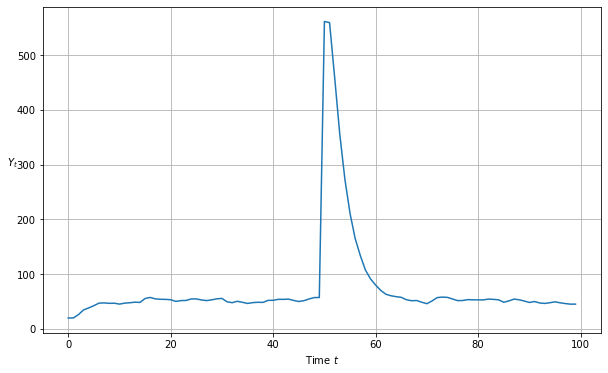

In [20]:
plot_y(y_stochastic_g(g=500, g_t=50, duration='one-off'))

## Wrapping Everything Into a Class

Up to now, we have written functions to do the work.

Now we’ll roll up our sleeves and write a Python class called `Samuelson`
for the Samuelson model

In [21]:
class Samuelson():

    """This class represents the Samuelson model, otherwise known as the
    multiple-accelerator model. The model combines the Keynesian multiplier
    with the accelerator theory of investment.

    The path of output is governed by a linear second-order difference equation

    .. math::

        Y_t =  + \alpha (1 + \beta) Y_{t-1} - \alpha \beta Y_{t-2}

    Parameters
    ----------
    y_0 : scalar
        Initial condition for Y_0
    y_1 : scalar
        Initial condition for Y_1
    α : scalar
        Marginal propensity to consume
    β : scalar
        Accelerator coefficient
    n : int
        Number of iterations
    σ : scalar
        Volatility parameter. It must be greater than or equal to 0. Set
        equal to 0 for a non-stochastic model.
    g : scalar
        Government spending shock
    g_t : int
        Time at which government spending shock occurs. Must be specified
        when duration != None.
    duration : {None, 'permanent', 'one-off'}
        Specifies type of government spending shock. If none, government
        spending equal to g for all t.

    """

    def __init__(self,
                 y_0=100,
                 y_1=50,
                 α=1.3,
                 β=0.2,
                 γ=10,
                 n=100,
                 σ=0,
                 g=0,
                 g_t=0,
                 duration=None):

        self.y_0, self.y_1, self.α, self.β = y_0, y_1, α, β
        self.n, self.g, self.g_t, self.duration = n, g, g_t, duration
        self.γ, self.σ = γ, σ
        self.ρ1 = α + β
        self.ρ2 = -β
        self.roots = np.roots([1, -self.ρ1, -self.ρ2])

    def root_type(self):
        if all(isinstance(root, complex) for root in self.roots):
            return 'Complex conjugate'
        elif len(self.roots) > 1:
            return 'Double real'
        else:
            return 'Single real'

    def root_less_than_one(self):
        if all(abs(root) < 1 for root in self.roots):
            return True

    def solution_type(self):
        ρ1, ρ2 = self.ρ1, self.ρ2
        discriminant = ρ1 ** 2 + 4 * ρ2
        if ρ2 >= 1 + ρ1 or ρ2 <= -1:
            return 'Explosive oscillations'
        elif ρ1 + ρ2 >= 1:
            return 'Explosive growth'
        elif discriminant < 0:
            return 'Damped oscillations'
        else:
            return 'Steady state'

    def _transition(self, x, t, g):

        # Non-stochastic - separated to avoid generating random series
        # when not needed
        if self.σ == 0:
            return self.ρ1 * x[t - 1] + self.ρ2 * x[t - 2] + self.γ + g

        # Stochastic
        else:
            ϵ = np.random.normal(0, 1, self.n)
            return self.ρ1 * x[t - 1] + self.ρ2 * x[t - 2] + self.γ + g \
                + self.σ * ϵ[t]

    def generate_series(self):

        # Create list and set initial conditions
        y_t = [self.y_0, self.y_1]

        # Generate y_t series
        for t in range(2, self.n):

            # No government spending
            if self.g == 0:
                y_t.append(self._transition(y_t, t))

            # Government spending (no shock)
            elif self.g != 0 and self.duration == None:
                y_t.append(self._transition(y_t, t))

            # Permanent government spending shock
            elif self.duration == 'permanent':
                if t < self.g_t:
                    y_t.append(self._transition(y_t, t, g=0))
                else:
                    y_t.append(self._transition(y_t, t, g=self.g))

            # One-off government spending shock
            elif self.duration == 'one-off':
                if t == self.g_t:
                    y_t.append(self._transition(y_t, t, g=self.g))
                else:
                    y_t.append(self._transition(y_t, t, g=0))
        return y_t

    def summary(self):
        print('Summary\n' + '-' * 50)
        print(f'Root type: {self.root_type()}')
        print(f'Solution type: {self.solution_type()}')
        print(f'Roots: {str(self.roots)}')

        if self.root_less_than_one() == True:
            print('Absolute value of roots is less than one')
        else:
            print('Absolute value of roots is not less than one')

        if self.σ > 0:
            print('Stochastic series with σ = ' + str(self.σ))
        else:
            print('Non-stochastic series')

        if self.g != 0:
            print('Government spending equal to ' + str(self.g))

        if self.duration != None:
            print(self.duration.capitalize() +
                  ' government spending shock at t = ' + str(self.g_t))

    def plot(self):
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(self.generate_series())
        ax.set(xlabel='Iteration', xlim=(0, self.n))
        ax.set_ylabel('$Y_t$', rotation=0)
        ax.grid()

        # Add parameter values to plot
        paramstr = f'$\\alpha={self.α:.2f}$ \n $\\beta={self.β:.2f}$ \n \
        $\\gamma={self.γ:.2f}$ \n $\\sigma={self.σ:.2f}$ \n \
        $\\rho_1={self.ρ1:.2f}$ \n $\\rho_2={self.ρ2:.2f}$'
        props = dict(fc='white', pad=10, alpha=0.5)
        ax.text(0.87, 0.05, paramstr, transform=ax.transAxes,
                fontsize=12, bbox=props, va='bottom')

        return fig

    def param_plot(self):

        # Uses the param_plot() function defined earlier (it is then able
        # to be used standalone or as part of the model)

        fig = param_plot()
        ax = fig.gca()

        # Add λ values to legend
        for i, root in enumerate(self.roots):
            if isinstance(root, complex):
                # Need to fill operator for positive as string is split apart
                operator = ['+', '']
                label = rf'$\lambda_{i+1} = {sam.roots[i].real:.2f} \
                    {operator[i]} {sam.roots[i].imag:.2f}i$'
            else:
                label = rf'$\lambda_{i+1} = {sam.roots[i].real:.2f}$'
            ax.scatter(0, 0, 0, label=label) # dummy to add to legend

        # Add ρ pair to plot
        ax.scatter(self.ρ1, self.ρ2, 100, 'red', '+',
            label=r'$(\ \rho_1, \ \rho_2 \ )$', zorder=5)

        plt.legend(fontsize=12, loc=3)

        return fig

### Illustration of Samuelson Class

Now we’ll put our Samuelson class to work on an example

In [22]:
sam = Samuelson(α=0.8, β=0.5, σ=2, g=10, g_t=20, duration='permanent')
sam.summary()

Summary
--------------------------------------------------
Root type: Complex conjugate
Solution type: Damped oscillations
Roots: [0.65+0.27838822j 0.65-0.27838822j]
Absolute value of roots is less than one
Stochastic series with σ = 2
Government spending equal to 10
Permanent government spending shock at t = 20


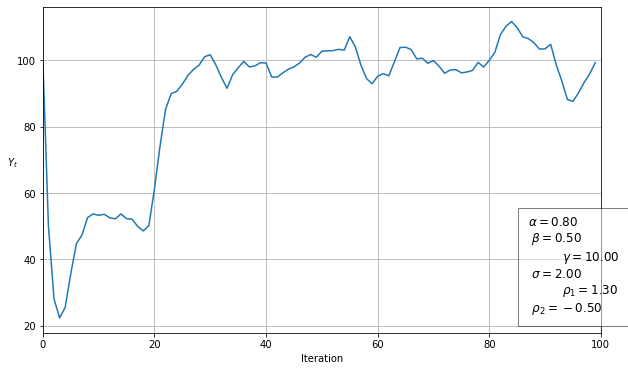

In [23]:
sam.plot()
plt.show()

### Using the Graph

We’ll use our graph to show where the roots lie and how their location
is consistent with the behavior of the path just graphed.

The red $ + $ sign shows the location of the roots

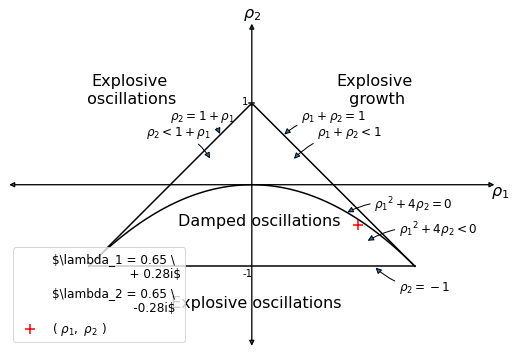

In [24]:
sam.param_plot()
plt.show()

## Using the LinearStateSpace Class

It turns out that we can use the [QuantEcon.py](http://quantecon.org/quantecon-py)
[LinearStateSpace](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/lss.py) class to do
much of the work that we have done from scratch above.

Here is how we map the Samuelson model into an instance of a
`LinearStateSpace` class

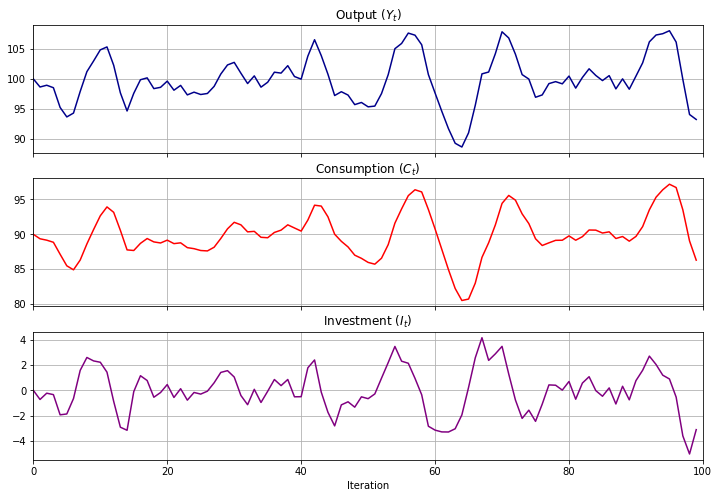

In [25]:
"""This script maps the Samuelson model in the the
``LinearStateSpace`` class
"""
α = 0.8
β = 0.9
ρ1 = α + β
ρ2 = -β
γ = 10
σ = 1
g = 10
n = 100

A = [[1,        0,      0],
     [γ + g,   ρ1,     ρ2],
     [0,        1,      0]]

G = [[γ + g, ρ1,   ρ2],         # this is Y_{t+1}
     [γ,      α,    0],         # this is C_{t+1}
     [0,      β,   -β]]         # this is I_{t+1}

μ_0 = [1, 100, 100]
C = np.zeros((3,1))
C[1] = σ # stochastic

sam_t = LinearStateSpace(A, C, G, mu_0=μ_0)

x, y = sam_t.simulate(ts_length=n)

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
titles = ['Output ($Y_t$)', 'Consumption ($C_t$)', 'Investment ($I_t$)']
colors = ['darkblue', 'red', 'purple']
for ax, series, title, color in zip(axes, y, titles, colors):
    ax.plot(series, color=color)
    ax.set(title=title, xlim=(0, n))
    ax.grid()

axes[-1].set_xlabel('Iteration')

plt.show()

### Other Methods in the `LinearStateSpace` Class

Let’s plot **impulse response functions** for the instance of the
Samuelson model using a method in the `LinearStateSpace` class

In [26]:
imres = sam_t.impulse_response()
imres = np.asarray(imres)
y1 = imres[:, :, 0]
y2 = imres[:, :, 1]
y1.shape

$$
\left ( 2, \quad 6, \quad 1\right )
$$

Now let’s compute the zeros of the characteristic polynomial by simply
calculating the eigenvalues of $ A $

In [27]:
A = np.asarray(A)
w, v = np.linalg.eig(A)
print(w)

[0.85+0.42130749j 0.85-0.42130749j 1.  +0.j        ]


### Inheriting Methods from `LinearStateSpace`

We could also create a subclass of `LinearStateSpace` (inheriting all its
methods and attributes) to add more functions to use

In [28]:
class SamuelsonLSS(LinearStateSpace):

    """
    This subclass creates a Samuelson multiplier-accelerator model
    as a linear state space system.
    """
    def __init__(self,
                 y_0=100,
                 y_1=100,
                 α=0.8,
                 β=0.9,
                 γ=10,
                 σ=1,
                 g=10):

        self.α, self.β = α, β
        self.y_0, self.y_1, self.g = y_0, y_1, g
        self.γ, self.σ = γ, σ

        # Define intial conditions
        self.μ_0 = [1, y_0, y_1]

        self.ρ1 = α + β
        self.ρ2 = -β

        # Define transition matrix
        self.A = [[1,                 0,         0],
                  [γ + g,       self.ρ1,   self.ρ2],
                  [0,                 1,         0]]

        # Define output matrix
        self.G = [[γ + g, self.ρ1, self.ρ2],         # this is Y_{t+1}
                  [γ,           α,       0],         # this is C_{t+1}
                  [0,           β,      -β]]         # this is I_{t+1}

        self.C = np.zeros((3, 1))
        self.C[1] = σ  # stochastic

        # Initialize LSS with parameters from Samuelson model
        LinearStateSpace.__init__(self, self.A, self.C, self.G, mu_0=self.μ_0)

    def plot_simulation(self, ts_length=100, stationary=True):

        # Temporarily store original parameters
        temp_μ = self.μ_0
        temp_Σ = self.Sigma_0

        # Set distribution parameters equal to their stationary
        # values for simulation
        if stationary == True:
            try:
                self.μ_x, self.μ_y, self.σ_x, self.σ_y = \
                    self.stationary_distributions()
                self.μ_0 = self.μ_y
                self.Σ_0 = self.σ_y
            # Exception where no convergence achieved when
            #calculating stationary distributions
            except ValueError:
                print('Stationary distribution does not exist')

        x, y = self.simulate(ts_length)

        fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
        titles = ['Output ($Y_t$)', 'Consumption ($C_t$)', 'Investment ($I_t$)']
        colors = ['darkblue', 'red', 'purple']
        for ax, series, title, color in zip(axes, y, titles, colors):
            ax.plot(series, color=color)
            ax.set(title=title, xlim=(0, n))
            ax.grid()

        axes[-1].set_xlabel('Iteration')

        # Reset distribution parameters to their initial values
        self.μ_0 = temp_μ
        self.Sigma_0 = temp_Σ

        return fig

    def plot_irf(self, j=5):

        x, y = self.impulse_response(j)

        # Reshape into 3 x j matrix for plotting purposes
        yimf = np.array(y).flatten().reshape(j+1, 3).T

        fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
        labels = ['$Y_t$', '$C_t$', '$I_t$']
        colors = ['darkblue', 'red', 'purple']
        for ax, series, label, color in zip(axes, yimf, labels, colors):
            ax.plot(series, color=color)
            ax.set(xlim=(0, j))
            ax.set_ylabel(label, rotation=0, fontsize=14, labelpad=10)
            ax.grid()

        axes[0].set_title('Impulse Response Functions')
        axes[-1].set_xlabel('Iteration')

        return fig

    def multipliers(self, j=5):
        x, y = self.impulse_response(j)
        return np.sum(np.array(y).flatten().reshape(j+1, 3), axis=0)

### Illustrations

Let’s show how we can use the `SamuelsonLSS`

In [29]:
samlss = SamuelsonLSS()

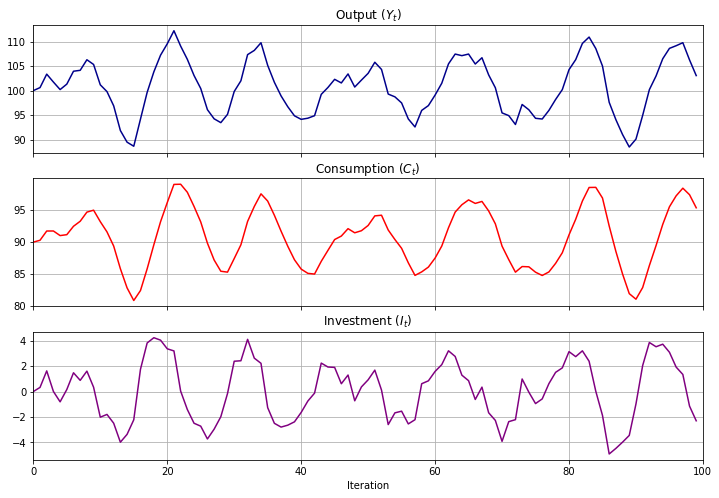

In [30]:
samlss.plot_simulation(100, stationary=False)
plt.show()

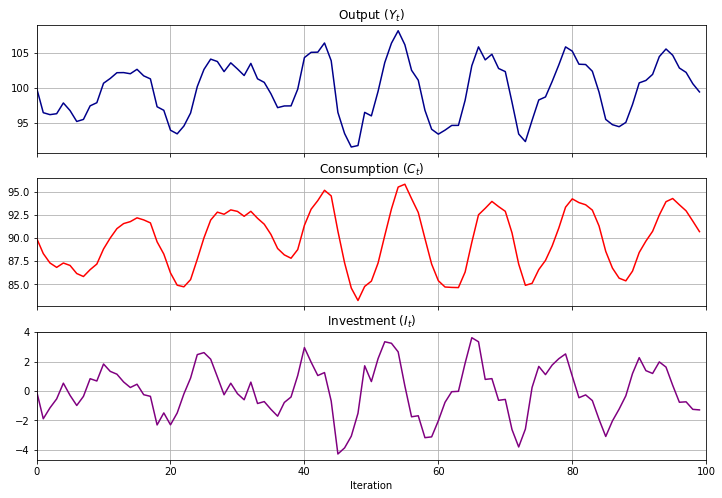

In [31]:
samlss.plot_simulation(100, stationary=True)
plt.show()

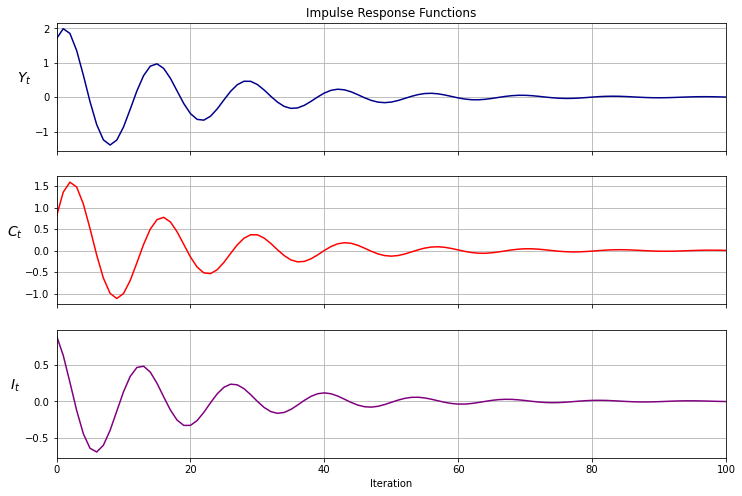

In [32]:
samlss.plot_irf(100)
plt.show()

In [33]:
samlss.multipliers()

array([7.414389, 6.835896, 0.578493])

## Pure Multiplier Model

Let’s shut down the accelerator by setting $ b=0 $ to get a pure
multiplier model

- the absence of cycles gives an idea about why Samuelson included the
  accelerator  

In [34]:
pure_multiplier = SamuelsonLSS(α=0.95, β=0)

Stationary distribution does not exist


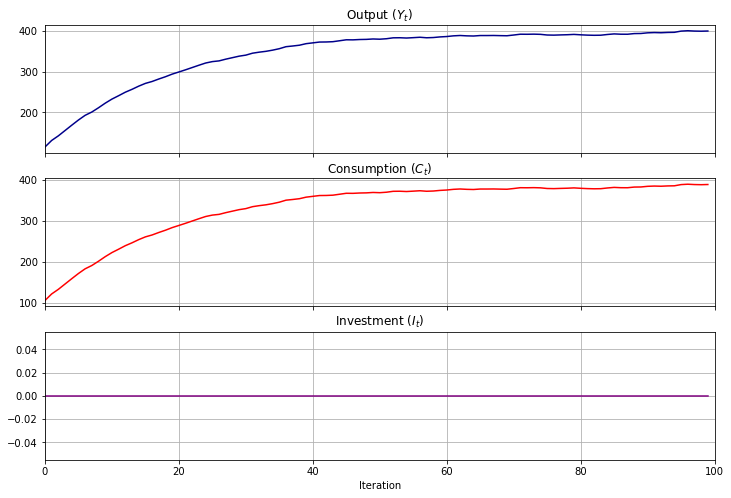

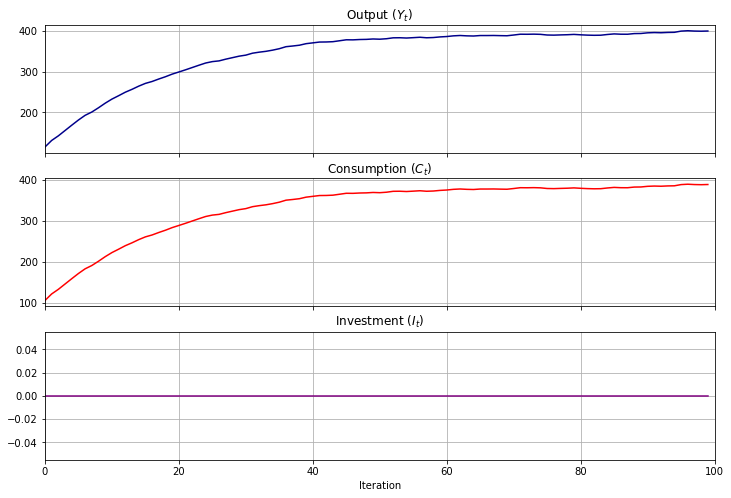

In [35]:
pure_multiplier.plot_simulation()

In [36]:
pure_multiplier = SamuelsonLSS(α=0.8, β=0)

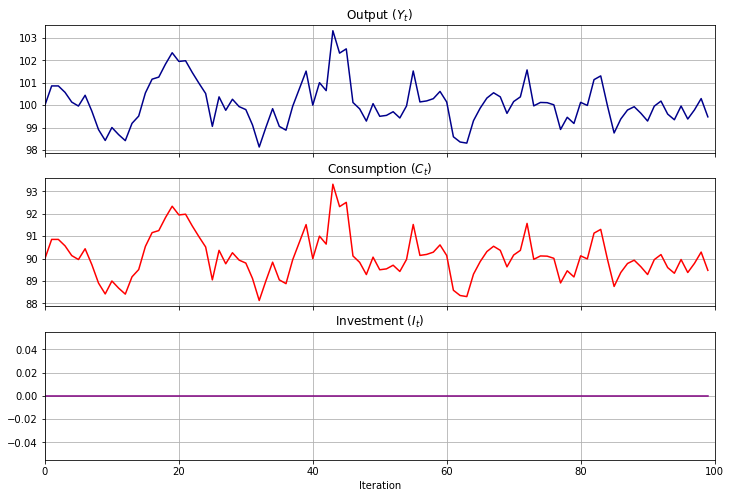

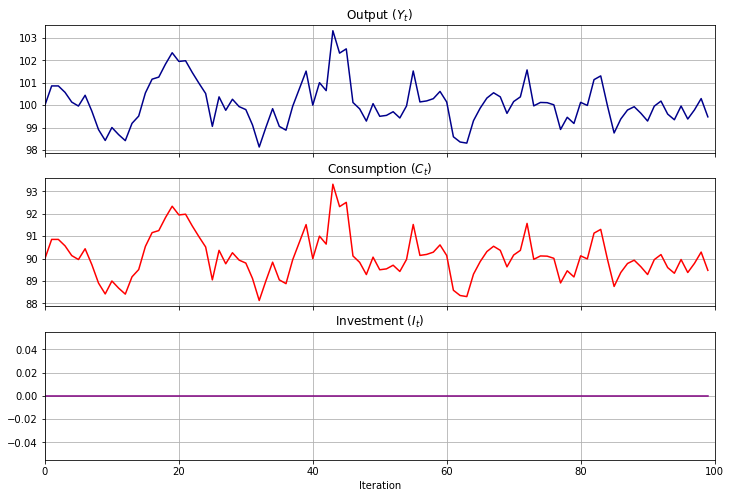

In [37]:
pure_multiplier.plot_simulation()

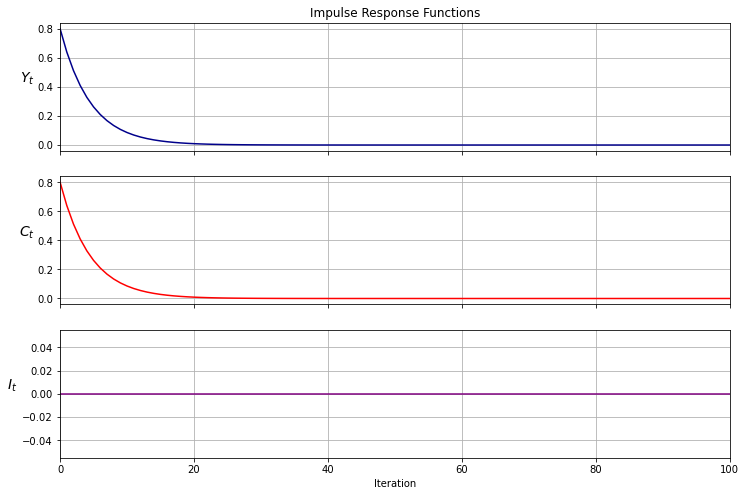

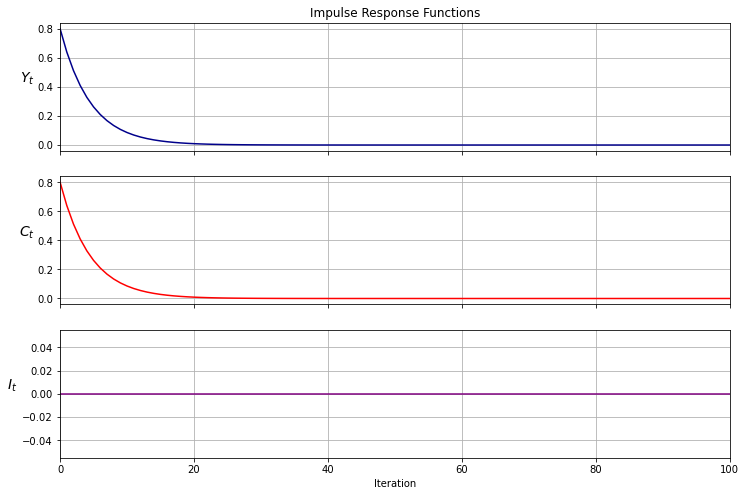

In [38]:
pure_multiplier.plot_irf(100)

## Summary

In this lecture, we wrote functions and classes to represent non-stochastic and
stochastic versions of the Samuelson (1939) multiplier-accelerator model, described
in [[Sam39]](https://python.quantecon.org/zreferences.html#samuelson1939).

We saw that different parameter values led to different output paths, which
could either be stationary, explosive, or oscillating.

We also were able to represent the model using the [QuantEcon.py](http://quantecon.org/quantecon-py)
[LinearStateSpace](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/lss.py) class.